## Visualization Step

In [1]:
import os
wav_path = "./data/Actor_02/03-01-02-02-02-02-02.wav"

print("exists?", os.path.exists(wav_path))

exists? True


In [2]:
import torchaudio

waveform, sr = torchaudio.load(wav_path)
print(waveform.shape, sr)

torch.Size([1, 196997]) 48000


In [3]:
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)
print("Mono shape:", waveform.shape)

Mono shape: torch.Size([1, 196997])


In [4]:
import torchaudio.transforms as ta

target_sr = 16000
if sr != target_sr:
    resampler = ta.Resample(orig_freq=sr, new_freq=target_sr)
    waveform = resampler(waveform)
    sr = target_sr
print("Resampled shape:", waveform.shape, "sr:", sr)

Resampled shape: torch.Size([1, 65666]) sr: 16000


In [5]:
max_abs = waveform.abs().amax()
if max_abs > 0:
    waveform = waveform / max_abs

In [6]:
from IPython.display import Audio
Audio(waveform.squeeze(0).numpy(), rate=sr)

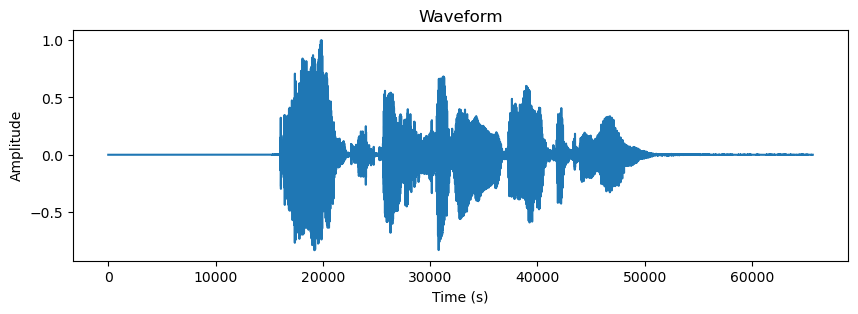

In [7]:
import matplotlib.pyplot as plt
import torch

T = waveform.shape[-1]
t = torch.arange(T)

plt.figure(figsize=(10,3))
plt.plot(t.numpy(), waveform.squeeze(0).numpy())
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

In [8]:
n_mels = 64
win_ms, hop_ms = 25, 10
win_length = int(sr * win_ms / 1000)
hop_length = int(sr * hop_ms / 1000)

import math
n_fft = 1 << (win_length - 1).bit_length() # converts the win_length into the next power of 2

melspec = ta.MelSpectrogram(
    sample_rate=sr,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
    f_min=0.0,
    f_max=None,
    power=2.0,
    center=True,
    pad_mode="reflect",
)
to_db = ta.AmplitudeToDB(stype="power")
mel = melspec(waveform)
mel_db = to_db(mel).squeeze(0)
mel_db.shape

torch.Size([64, 411])

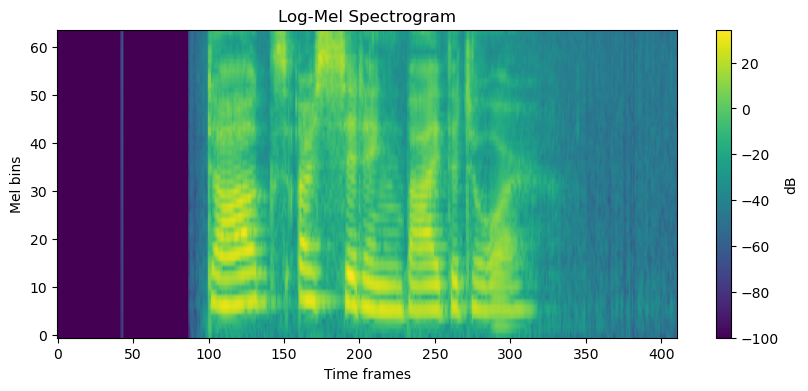

In [9]:
plt.figure(figsize=(10,4))
plt.imshow(mel_db.numpy(), origin="lower", aspect="auto")
plt.colorbar(label="dB")
plt.ylabel("Mel bins")
plt.xlabel("Time frames")
plt.title("Log-Mel Spectrogram")
plt.show()

In [10]:
n_mfcc = 20
n_mels = 64
win_ms, hop_ms = 25, 10
win_length = int(sr * win_ms / 1000)
hop_length = int(sr * hop_ms / 1000)

import math
n_fft = 1 << (win_length - 1).bit_length()

mfcc_tf = ta.MFCC(
    sample_rate=sr,
    n_mfcc=n_mfcc,
    melkwargs=dict(
        win_length=win_length,
        hop_length=hop_length,
        n_mels=n_mels,
        f_min=0,
        f_max=None,
        center=True,
        pad_mode="reflect",
        power=2.0,
    ),
)

mfcc = mfcc_tf(waveform)
mfcc = mfcc.squeeze(0)
mfcc.shape

torch.Size([20, 411])

In [11]:
import os
import pandas as pd

EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'}
DATA_PATH = "./data/Actor_02"

data = pd.DataFrame(columns=['Emotion', 'Emotion intensity', 'Gender','Path'])
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        identifiers = filename.split('.')[0].split('-')
        emotion = (int(identifiers[2]))
        if emotion == 8: 
            emotion = 0
        if int(identifiers[3]) == 1:
            emotion_intensity = 'normal' 
        else:
            emotion_intensity = 'strong'
        if int(identifiers[6])%2 == 0:
            gender = 'female'
        else:
            gender = 'male'
        
        data.loc[len(data)] = {
                            "Emotion": emotion,
                            "Emotion intensity": emotion_intensity,
                            "Gender": gender,
                            "Path": file_path
                             }
        
print("Number of files:", len(data))
print(data.head())

Number of files: 60
   Emotion Emotion intensity  Gender                                      Path
0        6            normal  female  ./data/Actor_02/03-01-06-01-02-02-02.wav
1        5            normal  female  ./data/Actor_02/03-01-05-01-02-01-02.wav
2        5            strong  female  ./data/Actor_02/03-01-05-02-01-01-02.wav
3        6            strong  female  ./data/Actor_02/03-01-06-02-01-02-02.wav
4        4            normal  female  ./data/Actor_02/03-01-04-01-01-02-02.wav


In [12]:
data.shape, data.columns.tolist()

((60, 4), ['Emotion', 'Emotion intensity', 'Gender', 'Path'])

In [13]:
data['Emotion'].value_counts().sort_index()

Emotion
0    8
1    4
2    8
3    8
4    8
5    8
6    8
7    8
Name: count, dtype: int64

## Dataset & Dataloader

In [14]:
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as ta

class SERAudioDataset(Dataset):
    def __init__(self, 
                 df, 
                 sample_rate=16000, 
                 feature_type="mfcc",
                 win_ms=25,
                 hop_ms=10, 
                 n_mels=64,
                 n_mfcc=20,
                 mono=True, 
                 normalize_waveform=True
                 ):
        self.df = df.reset_index(drop=True)
        self.sample_rate = sample_rate
        self.feature_type = feature_type
        self.win_ms = win_ms
        self.hop_ms = hop_ms
        self.n_mels = n_mels
        self.n_mfcc = n_mfcc
        self.mono = mono
        self.normalize_waveform = normalize_waveform

        self.win_length = int(sample_rate * win_ms /1000)
        self.hop_length = int(sample_rate * hop_ms / 1000)

        self.mfcc_tf = None

        if self.feature_type == "mfcc":
           n_fft = 1 << (win_length - 1).bit_length()
           self.mfcc_tf = ta.MFCC(
                sample_rate=sr,
                n_mfcc=n_mfcc,
                melkwargs=dict(
                    n_fft=n_fft,
                    win_length=win_length,
                    hop_length=hop_length,
                    n_mels=n_mels,
                    f_min=0,
                    f_max=None,
                    center=True,
                    pad_mode="reflect",
                    power=2.0,
                ),
            ) 
        
        print("dataset created with", len(df), "files!")

    def __len__(self):
        return len(self.df)
        
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["Path"]
        label = int(row["Emotion"])

        waveform, sr = torchaudio.load(path)
        if self.mono and waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        if sr != self.sample_rate:
            resampler = ta.Resample(sr, self.sample_rate)
            waveform = resampler(waveform)
            sr = self.sample_rate

        if self.normalize_waveform:
            max_abs = waveform.abs().amax()
            if max_abs > 0:
                waveform = waveform / max_abs
        
        if self.feature_type == "mfcc":
            x = self.mfcc_tf(waveform).squeeze(0)
        elif self.feature_type == "waveform":
            x = waveform.squeeze(0)
        else:
            raise ValueError(f"Unknown feature type: {self.feature_type}")
        
        return x, label, path

   
def collate_mfcc(batch):
        xs, ys, paths = zip(*batch)
        lengths = torch.tensor([x.shape[1] for x in xs], dtype=torch.int64)
        T_max = int(lengths.max())
        xs_padded = torch.stack([
            torch.nn.functional.pad(x, (0, T_max - x.shape[1]))
            for x in xs
        ], dim=0)
        ys = torch.tensor(ys, dtype=torch.long)
        return xs_padded, lengths, ys, paths
    
    


In [15]:
import sys
sys.path.append("./src")



ds = SERAudioDataset(df=data, sample_rate=16000, feature_type="mfcc", n_mfcc=20)
loader = DataLoader(ds, batch_size=4, shuffle=True, collate_fn=collate_mfcc)

xb, lengths, yb, paths = next(iter(loader))
print(xb.shape)
print(lengths)
print(yb.shape)
print(paths[0])

dataset created with 60 files!
torch.Size([4, 20, 404])
tensor([374, 364, 404, 374])
torch.Size([4])
./data/Actor_02/03-01-06-01-02-02-02.wav


## Splitting data

In [16]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(
    data.index,
    test_size=0.2,
    stratify=data['Emotion'],
    random_state=42
)

len(train_idx), len(test_idx)

(48, 12)

In [17]:
import os, numpy as np

os.makedirs("splits", exist_ok=True)
np.save("splits/train_idx.npy", train_idx)
np.save("splits/test_idx.npy", test_idx)
["splits/train_idx.npy", "splits/test_idx.npy"]

['splits/train_idx.npy', 'splits/test_idx.npy']

In [18]:
ti = np.load("splits/train_idx.npy", allow_pickle=False)
te = np.load("splits/test_idx.npy",  allow_pickle=False)
len(ti), len(te), set(ti).isdisjoint(set(te)), sorted(ti)[:5], sorted(te)[:5]

(48, 12, True, [0, 1, 3, 4, 6], [2, 5, 11, 16, 23])

In [19]:
ti = np.load("splits/train_idx.npy")
te = np.load("splits/test_idx.npy")

train_df = data.loc[ti].reset_index(drop=True)
test_df  = data.loc[te].reset_index(drop=True)

train_df.shape, test_df.shape

((48, 4), (12, 4))

In [20]:
train_ds = SERAudioDataset(train_df, sample_rate=16000, feature_type="mfcc", n_mfcc=20)
test_ds  = SERAudioDataset(test_df,  sample_rate=16000, feature_type="mfcc", n_mfcc=20)

len(train_ds), len(test_ds)

dataset created with 48 files!
dataset created with 12 files!


(48, 12)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  collate_fn=collate_mfcc, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, collate_fn=collate_mfcc, num_workers=0)

len(train_loader), len(test_loader)

(6, 2)

# Model 

## Example

In [22]:
import torch, torch.nn as nn

class MFCCModel(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.layer = nn.Linear(20, 8)

    def forward(self, x):
        y = torch.mean(x, -1)
        y = self.layer(y)
        return y

In [23]:
from tqdm import tqdm
model = MFCCModel()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# xb, lengths, yb, paths = next(iter(loader))
for xb, lengths, yb, paths in tqdm(loader):
    y = model(xb)
    l = loss(y, yb)
    l.backward()
    optimizer.step()

100%|██████████| 15/15 [00:00<00:00, 56.05it/s]


In [24]:
l.detach().numpy()

array(268.0363, dtype=float32)

## Actual Model

In [25]:
import torch.nn.functional as F

def masked_mean(x: torch.Tensor, lengths: torch.Tensor):
    B, C, T = x.shape
    device = x.device
    t = torch.arange(T, device=device)[None, :]
    mask = (t < lengths[:, None]).float()
    mask = mask[:, None, :]
    denom = mask.sum(dim=2).clamp_min(1.0)
    mean = (x * mask).sum(dim=2) / denom
    return mean

class MFCCMeanLinear(nn.Module):
    def __init__(self, n_mfcc: int, n_classes: int):
        super().__init__()
        self.fc = nn.Linear(n_mfcc, n_classes)

        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor):
            feats = masked_mean(x, lengths)
            logits = self.fc(feats)
            return logits


In [26]:
model = MFCCMeanLinear(n_mfcc=20, n_classes=8)

xb, lengths, yb, _ = next(iter(train_loader))
logits = model(xb, lengths)
print(xb.shape, lengths.shape, logits.shape)

torch.Size([8, 20, 401]) torch.Size([8]) torch.Size([8, 8])


In [64]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.set_grad_enabled(True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MFCCMeanLinear(n_mfcc=20, n_classes=8).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

n_mfcc = 20
sum_, sum2, count = torch.zeros(n_mfcc), torch.zeros(n_mfcc), 0
with torch.no_grad():
    for xb, lengths, yb, _ in train_loader:
        f = masked_mean(xb, lengths)    
        sum_ += f.sum(0)
        sum2 += (f**2).sum(0)
        count += f.size(0)
feat_mean = sum_ / count
feat_var  = (sum2 / count) - feat_mean**2
feat_std  = feat_var.clamp_min(1e-8).sqrt()

m = feat_mean.to(device)
s = feat_std.to(device)


# Training loop
for epoch in range(40):
    model.train()
    total, correct, running_loss = 0, 0, 0.0

    for xb, lengths, yb, _ in train_loader:
        xb, lengths, yb = xb.to(device), lengths.to(device), yb.to(device)

        # Normalized values
        feats = masked_mean(xb, lengths)                 
        feats = (feats - m) / s                          
        logits = model.fc(feats)                         

        loss = criterion(logits, yb)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        running_loss += float(loss) * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total

    # Validation Loop
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, lengths, yb, _ in test_loader:
            xb, lengths, yb = xb.to(device), lengths.to(device), yb.to(device)

            feats = masked_mean(xb, lengths)
            feats = (feats - m) / s
            logits = model.fc(feats)
            loss = criterion(logits, yb)

            test_loss += float(loss) * xb.size(0)
            preds = logits.argmax(dim=1)
            test_correct += (preds == yb).sum().item()
            test_total += yb.size(0)
    
        test_loss = test_loss / test_total # rename! 

    print(f"epoch {epoch+1} | train loss {running_loss/total:.4f} | train acc {correct/total:.3f}  | test loss {test_loss:.4f} | test acc {test_correct/test_total:.3f}")

epoch 1 | train loss 2.3467 | train acc 0.125  | test loss 2.4199 | test acc 0.250
epoch 2 | train loss 2.2911 | train acc 0.125  | test loss 2.3772 | test acc 0.250
epoch 3 | train loss 2.2406 | train acc 0.125  | test loss 2.3365 | test acc 0.250
epoch 4 | train loss 2.1897 | train acc 0.167  | test loss 2.2983 | test acc 0.333
epoch 5 | train loss 2.1404 | train acc 0.167  | test loss 2.2614 | test acc 0.333
epoch 6 | train loss 2.0964 | train acc 0.188  | test loss 2.2250 | test acc 0.333
epoch 7 | train loss 2.0517 | train acc 0.229  | test loss 2.1899 | test acc 0.333
epoch 8 | train loss 2.0080 | train acc 0.229  | test loss 2.1573 | test acc 0.333
epoch 9 | train loss 1.9701 | train acc 0.229  | test loss 2.1265 | test acc 0.333
epoch 10 | train loss 1.9297 | train acc 0.229  | test loss 2.0936 | test acc 0.333
epoch 11 | train loss 1.8922 | train acc 0.250  | test loss 2.0642 | test acc 0.333
epoch 12 | train loss 1.8570 | train acc 0.271  | test loss 2.0341 | test acc 0.333
e